In [1]:
import os
import h5py
import corner
from chainconsumer import ChainConsumer
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl

from lenstronomy.Util import param_util
from slitronomy.Util.plot_util import log_cmap

convert_ellipticity = False
save_figure = True

In [2]:
analytical_data_path = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/real_lenses/SLACS/Data/from_Anowar'
sparsefit_data_path = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/real_lenses/SLACS/Models/results_sparse/'
hst_band_name = 'F555W'

In [3]:
object_name = 'SDSSJ1630+4520'
#object_name = 'SDSSJ1250+0523'

simu_id = 'model_SLACS_SDSSJ1630_F555W_200603-155747'
#simu_id = 'model_SLACS_SDSSJ1250_F555W_200605-083351'

image_file = 'image_{}_{}.h5'.format(object_name, hst_band_name)
posteriors_file = 'output_{}_sweep25.h5'.format(object_name)

with h5py.File(os.path.join(analytical_data_path, image_file), 'r') as f:
    print(f.keys())
    image = f['image_data'][()]

<KeysViewHDF5 ['background_rms', 'dec_at_xy_0', 'exposure_time', 'image_data', 'ra_at_xy_0', 'transform_pix2angle']>


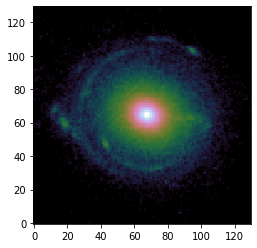

In [4]:
plt.imshow(image, origin='lower', cmap=log_cmap('cubehelix', 1e-2, 1))
plt.show()

## Visualize posteriors

In [5]:
# first n parameters to plot
n_keep_samples_analytical = 200000
n_keep_samples_sparse = 200000

In [6]:
# load posteriors from analytical fit
with h5py.File(os.path.join(analytical_data_path, posteriors_file), 'r') as f:
    fit_output = []
    group = f['fit_output']
    n = len(f['fit_output'].keys())
    #for index in [str(i) for i in range(n)]:
    #    fitting_step = [str(group[index].attrs['fitting_type'], encoding='utf-8')]
    #    print(fitting_step)
    
    # MCMC chains are the last element
    index_mcmc = str(n-1)
    samples_analytical = group[index_mcmc]['samples'][:]
    param_names_analytical = [str(s, encoding='utf-8') for s in group[index_mcmc]['param_list'][:]]
    logL_analytical = group[index_mcmc]['log_likelihood'][:]
    print("init chain", samples_analytical.shape)
    
# burnin the chain
if n_keep_samples_analytical is not None:
    samples_analytical = samples_analytical[-n_keep_samples_analytical:, :]

# remove parameters that are not fitted in sparse modelling: lens light + source light prameters
# WARNING: hard-coded number of lens mass parameters (8) here
param_names_analytical = param_names_analytical[:8]
samples_analytical = samples_analytical[:, :8]

# remove lens centroid that is not fitted in sparse modelling
idx_list = []
for p in ['center_x_l', 'center_y_l']:
    idx = param_names_analytical.index(p)
    idx_list.append(idx)
for idx in idx_list:
    param_names_analytical.pop(idx)
samples_analytical = np.delete(samples_analytical, idx_list, axis=1)  # delete corresponding columns
print(samples_analytical.shape, param_names_analytical)

init chain (1344000, 21)
(200000, 6) ['theta_E_le', 'gamma_lens', 'e1_lens0', 'e2_lens0', 'center_y_l', 'psi_ext_le']


In [7]:
# load posteriors from starlets modelling
result_backup = pkl.load(open(os.path.join(sparsefit_data_path, simu_id, 'result_backup.pkl'), 'rb'))
chain_list = result_backup['chain_list']
_, samples_sparse, param_names_sparse, logL_sparse = chain_list[-1]
print("init chain", samples_sparse.shape)

# number of walkers in the chain
walker_ratio = result_backup['fitting_list'][-1][1]['walkerRatio']
print("walker_ratio", walker_ratio)

# burnin the chain
if n_keep_samples_sparse is not None:
    samples_sparse = samples_sparse[-n_keep_samples_sparse:, :]
print(samples_sparse.shape, param_names_sparse)

init chain (150000, 6)
walker_ratio 10
(150000, 6) ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'gamma_ext_lens1', 'psi_ext_lens1']


In [8]:
# convert elliptitity e1 e2 parameters to axis ratio q and position angle phi
idx_e1, idx_e2 = 2, 3
if convert_ellipticity:
    phi, q = param_util.ellipticity2phi_q(samples_analytical[:, idx_e1], samples_analytical[:, idx_e2])
    samples_analytical[:, idx_e1], samples_analytical[:, idx_e2] = phi[:], q[:]
    phi, q = param_util.ellipticity2phi_q(samples_sparse[:, idx_e1], samples_sparse[:, idx_e2])
    samples_sparse[:, idx_e1], samples_sparse[:, idx_e2] = phi[:], q[:]

In [9]:
# prepare parameters names in latex format
param_names_latex = [
    r"$\theta_{\rm E}$",
    r"$\gamma'$",
    r"$e_1$",
    r"$e_2$",
    r"$\gamma_{\rm ext}$",
    r"$\psi_{\rm ext}$",
]
if convert_ellipticity:
    param_names_latex[idx_e1] = r"$\phi$"
    param_names_latex[idx_e2] = r"$q$"

In [10]:
# define bounds
ref_samples = samples_sparse
extents = [
    (np.median(ref_samples[:, 0])-0.02, np.median(ref_samples[:, 0])+0.02),  # theta_E
    (np.median(ref_samples[:, 1])-0.15, np.median(ref_samples[:, 1])+0.15),  # gamma
    (np.median(ref_samples[:, 2])-0.05, np.median(ref_samples[:, 2])+0.05),  # e1 / phi
    (np.median(ref_samples[:, 3])-0.05, np.median(ref_samples[:, 3])+0.05),  # e2 / q
    (0.01, np.median(ref_samples[:, 4])+0.02),  # gamma_ext
    (np.median(ref_samples[:, 5])-0.6, np.median(ref_samples[:, 5])+0.6),  # psi_ext
]

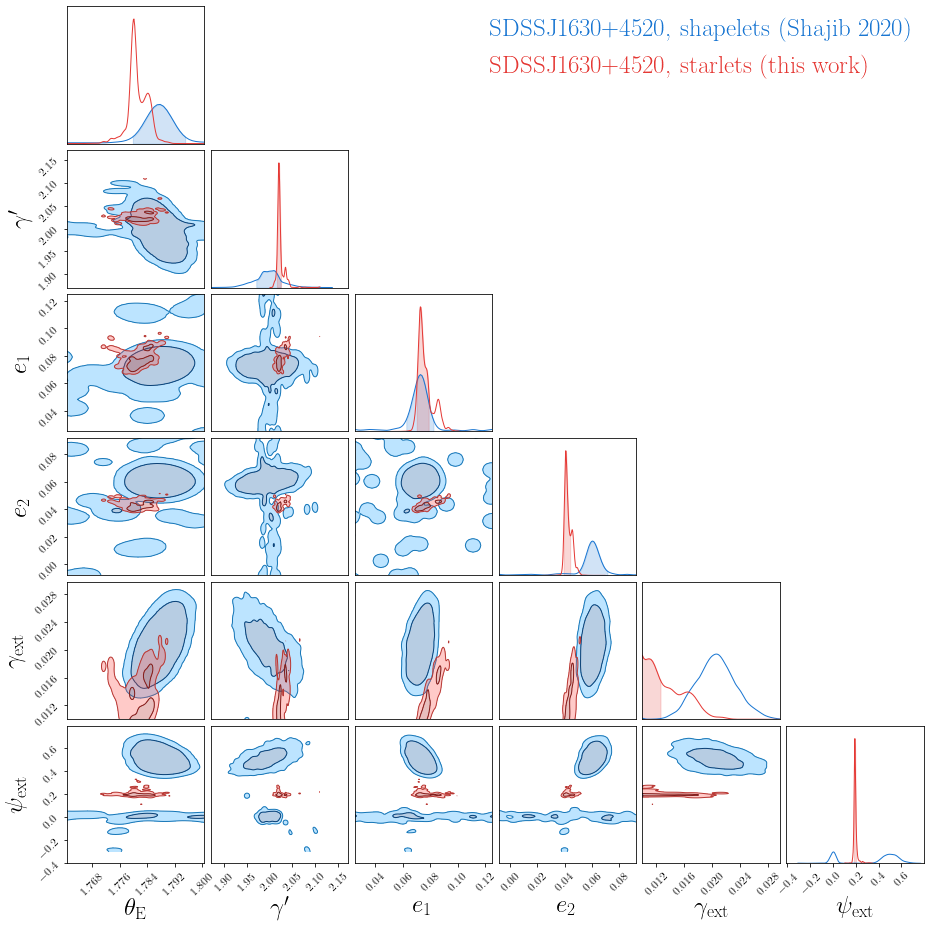

In [11]:
c = ChainConsumer()
c.add_chain(samples_analytical, name="{}, shapelets (Shajib 2020)".format(object_name), 
            parameters=param_names_latex, cloud=False,  #walkers=walker_ratio*len(param_names_latex),
            linewidth=1, color='blue')
c.add_chain(samples_sparse, name="{}, starlets (this work)".format(object_name), 
            parameters=param_names_latex, cloud=False,  #walkers=walker_ratio*len(param_names_latex),
            linewidth=1, color='red')
c.configure(sigmas=[1, 2], shade=True, shade_alpha=0.3, spacing=1, #smooth=0, linewidths=2,
            tick_font_size=12, label_font_size=25, max_ticks=6)
fig1 = c.plotter.plot(extents=extents)
fig1.set_size_inches(14, 14)
plt.show()

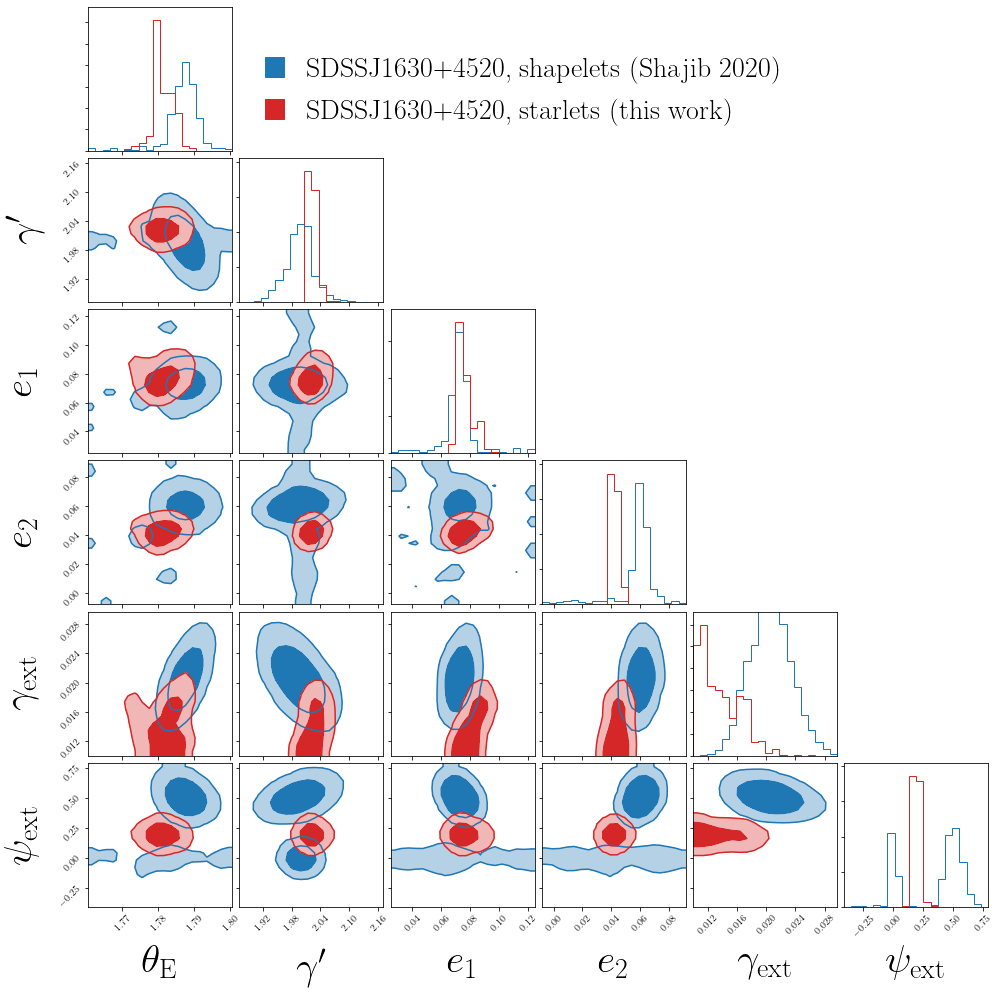

In [12]:
smooth, smooth_1d = 1, 1
fig2 = corner.corner(samples_analytical, labels=param_names_latex, show_titles=False, range=extents,
                    title_kwargs={'fontsize': 18}, label_kwargs={'fontsize': 40},
                    smooth=smooth, smooth_1d=smooth_1d, plot_datapoints=False, bins=20,
                    levels=[0.68, 0.95], fill_contours=True, alpha=0.8, color='tab:blue')
fig2 = corner.corner(samples_sparse, labels=param_names_latex, show_titles=False, range=extents,
                    title_kwargs={'fontsize': 18}, label_kwargs={'fontsize': 40},
                    smooth=smooth, smooth_1d=smooth_1d, plot_datapoints=False, bins=20,
                    levels=[0.68, 0.95], fill_contours=True, alpha=0.8, color='tab:red', fig=fig2)

ax = fig2.axes[1]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
patch_1 = mpatches.Patch(color='tab:blue', label="{}, shapelets (Shajib 2020)".format(object_name), alpha=1)
patch_2 = mpatches.Patch(color='tab:red', label="{}, starlets (this work)".format(object_name), alpha=1)
ax.legend(handles=[patch_1, patch_2], fontsize=28, handlelength=0.7, 
          loc='lower left', frameon=False)

plt.show()

In [13]:
# subgrid resolution used for that sampling
subgrid_res_source = result_backup['kwargs_sparse_solver']['subgrid_res_source']

# save the figure
if save_figure:
    fig_name = 'SLACS_sample-mass_{}_ssres{}.pdf'.format(object_name, subgrid_res_source)
    fig_path = os.path.join('figures', fig_name)
    fig2.savefig(fig_path, dpi=100, bbox_inches='tight')